In [37]:
import Robogame as rg
import networkx as nx
import altair as alt
import time, json
import pandas as pd
import numpy as np
import matplotlib as plt
import math

To start a game server go into the server directory. Make sure you have flask and networkx installed (```conda install networkx flask flask-cors requests scipy``` should do it).

To start a server do:

```python api.py [-d directoryforgame] [-s] [-t1s T1Secret] [-t2s T2Secret] gameid```

gameid is the the prefix of all the game files (the examples we gave you are examplematch1, examplematch2, examplematch3.

```
-d/--directory is an optional directory. For example, we put the examplematch1 files in the example1 directory
-s/--simulated tells us whether to simulate team 2
-t1s/--team1secret is Team 1's secret. If you don't specify this, the server will give you one
-t2s/--team1secret is Team 2's secret. This is ignored if you use -s. If you don't specify this, the server will give you one
-m/--matchsave is a log file to save the game in, a random log name will be used if you don't specify this
```

Here's a simple game:

```python api.py -d ./example1 -s -t1s bob examplematch1```

We're using the examplematch1 files in the example1 directory, simulating player 2 and team 1's secret is 'bob' (that's us)

In [38]:
# create a game connection using bob as the "secret" key for your team (this is what you're given by the server)
game = rg.Robogame("bob")

# the default is to the localhost on port 5000, if you want something else you can do:
# game = rg.Robogame("bob",server="12.12.31.1",port=2324)

Connected to server. The two teams are bobsTeam  and  Simulated 
Your team is team # 1


In [39]:
# tell the server we're ready to go
game.setReady()

{'Result': 'OK'}

In [40]:
# get the people who are play
game.getTeams()

{'Team1': 'bobsTeam', 'Team2': 'Simulated', 'You': 1}

In [41]:
game.getGameTime()

{'curtime': 0,
 'gameendtime_secs': 1702222545.761612,
 'gamestarttime_secs': 1702221945.761612,
 'servertime_secs': 1702221935.788119,
 'unitsleft': 100}

In [42]:
# get the current game time
# there is a buffer before the game actually starts once both teams are ready

# wait for both players to be ready
while(True):
    gametime = game.getGameTime()
    
    if ('Error' in gametime):
        if (gametime['Error'] == 'Game not started'):
            print("Game not started yet, waiting")
            time.sleep(1)
            continue
        else:
            print("Error"+str(gametime))
            break
    
    timetogo = gametime['gamestarttime_secs'] - gametime['servertime_secs']

    if (timetogo <= 0):
        print("Let's go!")
        break
        
    print("waiting to launch... game will start in " + str(int(timetogo)))
    time.sleep(1) # sleep 1 second at a time, wait for the game to start
    

waiting to launch... game will start in 9
waiting to launch... game will start in 8
waiting to launch... game will start in 7
waiting to launch... game will start in 6
waiting to launch... game will start in 5
waiting to launch... game will start in 4
waiting to launch... game will start in 3
waiting to launch... game will start in 2
waiting to launch... game will start in 1
waiting to launch... game will start in 0
Let's go!


In [43]:
# check the current game time
game.getGameTime()

{'curtime': 0.03,
 'gameendtime_secs': 1702222545.761612,
 'gamestarttime_secs': 1702221945.761612,
 'servertime_secs': 1702221945.964003,
 'unitsleft': 99.97}

In [44]:
# get the robot data (note that the bets column are the guesses your team has associated with the robots at the moment)
robots = game.getRobotInfo()

# if you want this in json format, do:
# robots = game.getRobotInfo(js=True)

In [45]:
# see what's inside
robots.sample(10)

,id,name,expires,winner,Productivity,winningTeam,bets
142,142,Thumpborer Botberg,NaN,-2,None,Unassigned,-1
141,141,Waterlift Boterson,NaN,-2,None,Unassigned,-1
144,144,Wallminer Botchik I,NaN,-2,None,Unassigned,-1
87,87,Wallwaller Botski,92.0,-2,None,Unassigned,-1
97,97,Stoneborer Botchik Jr.,26.0,-2,None,Unassigned,-1
35,35,Waterborer Botsky II,56.0,-2,None,Unassigned,-1
9,9,Wallvator Boterson,71.0,-2,None,Unassigned,-1
67,67,Extraborer Botsky,86.0,-2,None,Unassigned,-1
8,8,Wallborer Botski,61.0,-2,None,Unassigned,-1
147,147,Rockwalker Botson II,NaN,-2,None,Unassigned,-1


In [46]:
# let's plot the distribution of expirations
alt.Chart(robots).mark_bar().encode(
    alt.X("expires:Q", bin=True),
    y='count()',
)

/opt/homebrew/anaconda3/envs/548-robo/lib/python3.9/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/homebrew/anaconda3/envs/548-robo/lib/python3.9/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [47]:
# grab the networks
network = game.getNetwork()

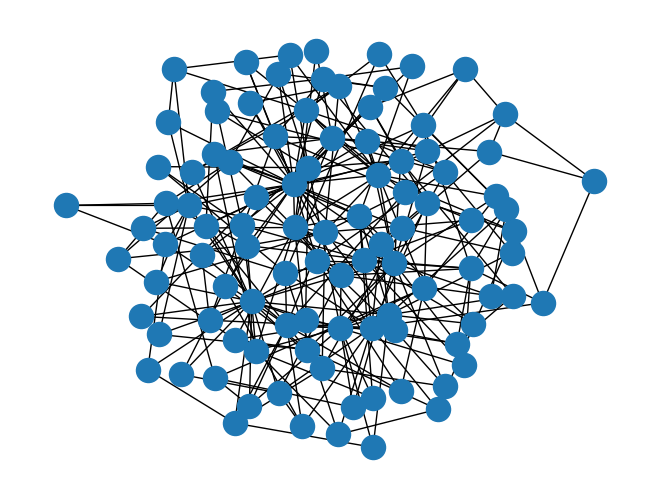

In [48]:
# use the networkx package to parse it and plot it
socialnet = nx.node_link_graph(network)
robotDegrees = {node:val for (node, val) in socialnet.degree()}
nx.draw_kamada_kawai(socialnet)

In [49]:
def getAverageProductivity(neighbors, roboDict):
    total = 0
    count = 0
    for neighborId in neighbors:
        productivity = roboDict[neighborId]["Productivity"]
        if productivity is not None and not math.isnan(productivity):
            total += productivity
            count += 1
            
    if count == 0:
        return 0
    return total / count

In [50]:
g = socialnet.neighbors(3)

In [51]:
robots = game.getRobotInfo()
robotRecords = robots.to_dict("records")

In [52]:
socialnet.neighbors(3)
for i in socialnet.neighbors(3):
    print(type(i))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [53]:
getAverageProductivity(socialnet.neighbors(3), robotRecords)

0

In [54]:
network.keys()

dict_keys(['directed', 'graph', 'links', 'multigraph', 'nodes'])

In [55]:
# get the genealogy tree
tree = game.getTree()
tree

{'children': [{'children': [{'id': 89}, {'id': 19}], 'id': 133},
  {'children': [{'children': [{'children': [{'children': [{'id': 24},
          {'id': 17}],
         'id': 101},
        {'children': [{'children': [{'id': 88}, {'id': 23}, {'id': 46}],
           'id': 119},
          {'id': 25}],
         'id': 120},
        {'id': 27},
        {'id': 42}],
       'id': 132},
      {'children': [{'children': [{'id': 75},
          {'id': 72},
          {'id': 39},
          {'id': 55}],
         'id': 107},
        {'children': [{'children': [{'id': 66}, {'id': 95}, {'id': 99}],
           'id': 105},
          {'id': 94},
          {'id': 67}],
         'id': 141}],
       'id': 142}],
     'id': 145},
    {'children': [{'children': [{'children': [{'children': [{'id': 54},
            {'id': 96},
            {'id': 38}],
           'id': 123},
          {'children': [{'children': [{'id': 71}, {'id': 44}], 'id': 106},
            {'children': [{'children': [{'children': [{'id': 58},
  

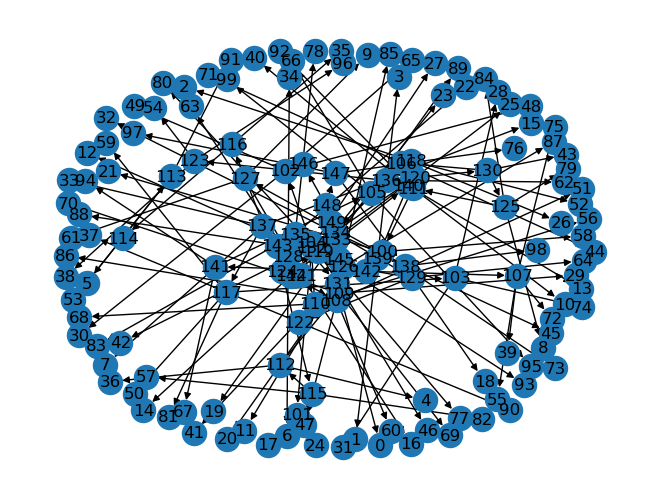

In [56]:
# use networkx to parse and plot it
genealogy = nx.tree_graph(tree)
# genealogy.neighbors(3)
# for i in genealogy.all_neighbors(3):
#     print(type(i))
nx.draw(genealogy,with_labels = True)

In [58]:
for i in range(100):
    neighbors = nx.all_neighbors(genealogy, i)
    twoDistAway = set()
    for neighbor in neighbors:
        twoDist = nx.all_neighbors(genealogy, neighbor)
        for node in twoDist:
            twoDistAway.add(node)
    print(f"{i}: ", list(twoDistAway))

0:  [0, 20, 85, 135]
1:  [1, 3, 140]
2:  [26, 2, 140, 52]
3:  [1, 3, 140]
4:  [4, 115, 36, 109]
5:  [114, 91, 5]
6:  [129, 34, 6]
7:  [33, 7, 15, 143, 117]
8:  [130, 8, 79, 111, 84]
9:  [121, 138, 61, 9]
10:  [10, 100, 125, 92]
11:  [134, 11, 12, 87, 93]
12:  [134, 11, 12, 87, 93]
13:  [40, 139, 13, 144, 118]
14:  [136, 140, 14, 143, 146]
15:  [33, 7, 15, 143, 117]
16:  [16, 63, 127]
17:  [24, 17, 132]
18:  [18, 98, 147, 127]
19:  [89, 19, 149]
20:  [0, 20, 85, 135]
21:  [73, 58, 21, 111]
22:  [131, 110, 143, 83, 22]
23:  [120, 88, 46, 23]
24:  [24, 17, 132]
25:  [25, 132, 119]
26:  [26, 2, 140, 52]
27:  [101, 42, 145, 120, 27]
28:  [74, 28, 117, 31]
29:  [112, 69, 29, 70]
30:  [65, 104, 48, 49, 30]
31:  [74, 28, 117, 31]
32:  [32, 129, 136, 45, 126]
33:  [33, 7, 15, 143, 117]
34:  [129, 34, 6]
35:  [114, 35, 124]
36:  [4, 115, 36, 109]
37:  [129, 90, 37]
38:  [136, 38, 96, 54]
39:  [39, 72, 75, 142, 55]
40:  [40, 139, 13, 144, 118]
41:  [68, 135, 104, 41, 56]
42:  [101, 42, 145, 120, 

In [21]:
# we can get hints every 6 seconds or so, let's grab a few rounds of hints

# note that you can now do getHints(hintstart=4)  where the number indicates
# from when to give you the hints (so this will give you everything from time
# unit 4 until now)
for i in np.arange(0,3):
    # this will give us just the new hints, but the object will store everything we've seen
    hints = game.getHints()
    if ('parts' in hints):
        print('we got '+str(len(hints['parts']))+' part hints')
    time.sleep(6)


# get all the hints we've collected
predHints = game.getAllPredictionHints()
partHints = game.getAllPartHints()

we got 6 part hints
we got 6 part hints
we got 6 part hints


In [35]:
# make the time hints into a dataframe
predhints_df = pd.read_json(json.dumps(predHints),orient='records')

/var/folders/26/31jzclbj3pdblmsypbbv4j9m0000gn/T/ipykernel_23043/2153857083.py:2: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  predhints_df = pd.read_json(json.dumps(predHints),orient='records')


In [18]:
# lets plot the data we got from all the robots
alt.Chart(predhints_df).mark_point().encode(
    x='time:Q',
    y='mean(value):Q'
)

alt.Chart(...)

In [19]:
# we can tell the hacker we're interested in robots 99, 23 and 1
game.setRobotInterest([99,23,5])

# to reset to being interested in all, use
# game.setRobotInterest([])

{'Result': 'OK'}

In [20]:
# we can also tell the hacker we're interesed in the 'Astrogation Buffer Length','InfoCore Size'
game.setPartInterest(['Astrogation Buffer Length','InfoCore Size'])

# to reset to being interested in all, use
# game.setPartInterest([])

{'Result': 'OK'}

In [21]:
# if we get more hints now, they'll be biased to the robots and parts we care about

for i in np.arange(0,3):
    # this will give us just the new hints, but the object will store everything we've seen
    hints = game.getHints()
    if ('parts' in hints):
        print('we got '+str(len(hints['parts']))+' part hints')
    time.sleep(6)

we got 12 part hints
we got 12 part hints
we got 12 part hints


In [22]:
# to set our bets, feed in a dictionary with the values
# for example, let's set robot id 0 to 99 and robot 5 to 72
game.setBets({0:99,5:72})

{'Result': 'OK'}

In [23]:
# let's see how we're doing, grab the data
robots = game.getRobotInfo()

In [24]:
# let's see how team 2 is doing (might be 0 if no deadlines expired)
robots[robots.winner == 2]['Productivity'].sum()

0

In [25]:
# let's see how team 1 is doing (might be 0 if no deadlines expired or we didn't put in any bets)
robots[robots.winner == 1]['Productivity'].sum()

0

In [26]:
# Here's a hint on how you can use the data you get to predict the value.
# Let's say we learn two points about a robot's random number generator
# At time 17, they'll say 40 and at time 50, they'll say 27
xs = [17,50]
ys = [40,27]

In [27]:
# we can use this to generate simple regression. One way to do it is to just fit a one dimensional polynomial
fit = np.polyfit(xs,ys,1)

# in reality, 1 dimension is probably not ideal

In [28]:
# next, we'll want to figure out all the y values over the range of times 0 to 100
fitx = np.arange(0,100)
fity = []

In [29]:
# create the fit function using the fit we calculated above
fitfunc = np.poly1d(fit)
for x in fitx:
    y = fitfunc(x)
    if (y > 100): # we know y can't be > 100
        y = 100
    if (y < 0): # we know y can't be < 0
        y = 0
    fity.append(y)

In [30]:
# to visualize this, I'm going to build a dataset the has both the original numbers 
# our hacker gave us (17,50 and 40,27) and the new things we calculated:
vals = []
for i in np.arange(0,len(xs)):
    vals.append({'t':'hint','x':int(xs[i]),'y':int(ys[i])})
   
for i in np.arange(0,len(fitx)):
    vals.append({'t':'fit','x':int(fitx[i]),'y':int(fity[i])})

# so now we have a dataset with both the hint and fit data
# you can look at it here
# vals

In [31]:
# finally, let's plot the data using Altair

# first make a chart for the hints
hintlayer = alt.Chart(alt.Data(values=vals)).mark_circle(filled=True,size=90,color='red').encode(
    x='x:Q',
    y='y:Q',
    color='t:N'
).transform_filter(
    alt.datum.t == 'hint'
)

# overlay that with the predictions
fitlayer = alt.Chart(alt.Data(values=vals)).mark_line().encode(
    x='x:Q',
    y='y:Q',
    color='t:N'
).transform_filter(
    alt.datum.t == 'fit'
)

# and let's assume an expiration of 70 for this robot and draw a line on top

annotationlayer = alt.Chart(pd.DataFrame({'x': [70]})).mark_rule().encode(x='x:Q')

# layer the charts
hintlayer + fitlayer + annotationlayer


alt.LayerChart(...)

## A few other random "recipes"

In [32]:
# set all the bets to 80
bets = {}
for i in np.arange(0,100):
    bets[int(i)] = int(80)
game.setBets(bets)

{'Result': 'OK'}

In [33]:
# get all the game parts since the start of the game
game.getHints(hintstart=0)['parts']

[{'column': 'Nanochip Model', 'id': 77, 'value': 'windows 2000'},
 {'column': 'Polarity Sinks', 'id': 66, 'value': 0.503602380674975},
 {'column': 'Sonoreceptors', 'id': 94, 'value': 92.0},
 {'column': 'Repulsorlift Motor HP', 'id': 47, 'value': 1.149488398735601},
 {'column': 'Astrogation Buffer Length',
  'id': 17,
  'value': -0.0636855489501504},
 {'column': 'AutoTerrain Tread Count', 'id': 1, 'value': 1.7659558308772216},
 {'column': 'Polarity Sinks', 'id': 58, 'value': 0.5735011489030041},
 {'column': 'Repulsorlift Motor HP', 'id': 41, 'value': 1.6139939841839024},
 {'column': 'Arakyd Vocabulator Model', 'id': 10, 'value': 'alpha'},
 {'column': 'Cranial Uplink Bandwidth', 'id': 40, 'value': 61.0},
 {'column': 'Polarity Sinks', 'id': 46, 'value': 0.5929807563106743},
 {'column': 'InfoCore Size', 'id': 53, 'value': -0.2009266309303803},
 {'column': 'Repulsorlift Motor HP', 'id': 66, 'value': 1.2044165503003177},
 {'column': 'Polarity Sinks', 'id': 94, 'value': 0.414852758415624},
 {

In [34]:
# debug information while game is in simulation
game.getDebug()

{'team1secret': 'bob',
 'team2secret': 'f965b1b6-98fb-4d5b-a976-0d0ad616cef0',
 'team1_int_bots': [[],
  [],
  [],
  [99, 23, 5],
  [99, 23, 5],
  [99, 23, 5],
  [99, 23, 5],
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'team2_int_bots': [[],
  [],
  [],
  [],
  [],
  [],
  [],
  None,
  No